# 400_Advanced

In this notebook I will implement the advanced stage of the project which is to...
* Build a recommender model capable of recommending new training targets for individual athletes, based on their completed sessions to-date. These targets will help the athletes to achieve their desired finish time in the eventual marathon race.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#400_Advanced" data-toc-modified-id="400_Advanced-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>400_Advanced</a></span></li><li><span><a href="#Notebook-Set-Up" data-toc-modified-id="Notebook-Set-Up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notebook Set Up</a></span><ul class="toc-item"><li><span><a href="#Import-Packages" data-toc-modified-id="Import-Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import Packages</a></span></li><li><span><a href="#Set-Parameters-For-Graphs" data-toc-modified-id="Set-Parameters-For-Graphs-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Set Parameters For Graphs</a></span></li></ul></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Advanced" data-toc-modified-id="Advanced-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Advanced</a></span><ul class="toc-item"><li><span><a href="#Step-1:-Extract-the-Features" data-toc-modified-id="Step-1:-Extract-the-Features-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Step 1: Extract the Features</a></span></li><li><span><a href="#Step-2:-Choose-Test-Athlete" data-toc-modified-id="Step-2:-Choose-Test-Athlete-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Step 2: Choose Test Athlete</a></span></li><li><span><a href="#Step-3:-Find-Neighbourhood-Of-Test-Athlete" data-toc-modified-id="Step-3:-Find-Neighbourhood-Of-Test-Athlete-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Step 3: Find Neighbourhood Of Test Athlete</a></span></li><li><span><a href="#Step-4:-Find-The-Desired-Marathon-Finish-Time-Of-The-Athlete" data-toc-modified-id="Step-4:-Find-The-Desired-Marathon-Finish-Time-Of-The-Athlete-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Step 4: Find The Desired Marathon Finish Time Of The Athlete</a></span></li></ul></li><li><span><a href="#Output" data-toc-modified-id="Output-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Output</a></span><ul class="toc-item"><li><span><a href="#Recommend-New-Training-Targets" data-toc-modified-id="Recommend-New-Training-Targets-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Recommend New Training Targets</a></span></li><li><span><a href="#Percentage-Change-From-Current-Programme" data-toc-modified-id="Percentage-Change-From-Current-Programme-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Percentage Change From Current Programme</a></span></li></ul></li></ul></div>

# Notebook Set Up

## Import Packages

In [1]:
import pickle
import os.path
import numpy as np
import pandas as pd
from IPython import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tsfresh import extract_features, select_features
%matplotlib inline

## Set Parameters For Graphs

In [2]:
# Text, linees, and markers...
plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'

plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['axes.labelweight'] = 'bold'

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

plt.rcParams['axes.grid'] = True

plt.rcParams['lines.markersize'] = 15
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['legend.fontsize'] = 30

# Load Data

In [3]:
with open('../data/advanced/training_first_weeks_df.pkl', 'rb') as f:
    training_first_weeks_df = pickle.load(f)

In [4]:
with open('../data/advanced/training_last_weeks_df.pkl', 'rb') as f:
    training_last_weeks_df = pickle.load(f)

In [5]:
with open('../data/advanced/test_first_weeks_df.pkl', 'rb') as f:
    test_first_weeks_df = pickle.load(f)

# Advanced

## Step 1: Extract the Features

In [6]:
training_first_weeks_EF = training_first_weeks_df[['hashedathleteid','date','totaldistance','session_speed']]
test_first_weeks_EF = test_first_weeks_df[['hashedathleteid','date','totaldistance','session_speed']]

In [7]:
training_first_weeks_EF = extract_features(training_first_weeks_EF, column_id="hashedathleteid",column_sort="date")
test_first_weeks_EF = extract_features(test_first_weeks_EF, column_id="hashedathleteid",column_sort="date")

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 101.50it/s]


In [8]:
test_first_weeks_EF = test_first_weeks_EF.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
training_first_weeks_EF = training_first_weeks_EF.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

Find Common Finite Columns

In [9]:
common_columns = np.intersect1d(test_first_weeks_EF.columns, training_first_weeks_EF.columns)

In [10]:
training_first_weeks_EF = training_first_weeks_EF[common_columns]
test_first_weeks_EF = test_first_weeks_EF[common_columns]

In [11]:
training_first_weeks_EF.shape

(3116, 492)

In [12]:
test_first_weeks_EF.shape

(10, 492)

In [13]:
mft_df = training_first_weeks_df[['hashedathleteid','marathon_finish_time']]
mft_df = mft_df.set_index('hashedathleteid')
mft_dict = mft_df.T.squeeze().to_dict()

In [14]:
training_first_weeks_EF['marathon_finish_time'] = training_first_weeks_EF.index.map(mft_dict)

In [15]:
choose_athlete = widgets.Dropdown(
    options=test_first_weeks_EF.index,
    description='Athlete:',
    disabled=False,
)

## Step 2: Choose Test Athlete

I use a widget to allow the user to choose the test athlete

In [16]:
choose_athlete

Dropdown(description='Athlete:', options=('0e6d0e234ab5af0c16ade602c21c077b3f51ac0646472b5eeb1d5d449055f951', …

In [17]:
test_athlete = choose_athlete.value
test_athlete

'0e6d0e234ab5af0c16ade602c21c077b3f51ac0646472b5eeb1d5d449055f951'

In [18]:
test_athlete_first_weeks = test_first_weeks_EF[test_first_weeks_EF.index == test_athlete]

## Step 3: Find Neighbourhood Of Test Athlete

In [19]:
ten_percent_of_population = int(training_first_weeks_df['hashedathleteid'].nunique()*0.10)
nbrs = NearestNeighbors(n_neighbors=ten_percent_of_population,metric='euclidean').fit(training_first_weeks_EF[common_columns].values)
distances, indices = nbrs.kneighbors(test_athlete_first_weeks.values)

In [20]:
neighbourhood = training_first_weeks_EF.iloc[indices[0]]

## Step 4: Find The Desired Marathon Finish Time Of The Athlete

A predicted fininsh time is made by finding the average finish times of the test athlete. The test athlete is then able to enter a desired finish time. However the desired finish time must lie between 20% either side of the predicted time.

In [21]:
predicted_finish_time = neighbourhood.marathon_finish_time.mean()
predicted_finish_time

3.321859900268422

In [22]:
def f(desired_marathon_finish_time):
    return desired_marathon_finish_time

In [23]:
max_time = predicted_finish_time*1.2
min_time = predicted_finish_time*0.8

In [24]:
dmft =    widgets.FloatSlider(            \
            description = "Finish Time:", \
            min=min_time,                 \
            max=max_time,                 \
            step=0.01,value=predicted_finish_time)

In [25]:
display.display(dmft)

FloatSlider(value=3.321859900268422, description='Finish Time:', max=3.986231880322106, min=2.657487920214738,…

In [26]:
desired_marathon_finish_time = dmft.value

# Output

## Recommend New Training Targets

I will refrain from commenting as these results are discussed in create detail in the report.  

In [27]:
current_stats = test_first_weeks_df[['average_weekly_trainings','average_weekly_training_hours','average_weekly_totaldistance','totaldistance_std','session_speed','speed_std']].mean()
current_stats_df = current_stats.to_frame()
current_stats_df

,0
average_weekly_trainings,3.000000
average_weekly_training_hours,3.721716
average_weekly_totaldistance,39.358544
totaldistance_std,6.254126
session_speed,10.693909
speed_std,0.992535


In [28]:
recommended_targets = training_last_weeks_df[training_last_weeks_df['marathon_finish_time']<=desired_marathon_finish_time][['average_weekly_trainings','average_weekly_training_hours','average_weekly_totaldistance','totaldistance_std','session_speed','speed_std']].mean()
recommended_targets_df = recommended_targets.to_frame()
recommended_targets_df.columns = ['Targets']
recommended_targets_df

,Targets
average_weekly_trainings,4.312909
average_weekly_training_hours,5.218424
average_weekly_totaldistance,64.118554
totaldistance_std,8.295639
session_speed,12.476166
speed_std,1.491136


In [29]:
recommended_targets_df.to_json(r'../data/advanced/training_targets.json')

In [30]:
percentage_difference = ((recommended_targets/current_stats)-1)*100
percentage_difference

average_weekly_trainings         43.763627
average_weekly_training_hours    40.215559
average_weekly_totaldistance     62.908858
totaldistance_std                32.642664
session_speed                    16.666094
speed_std                        50.235123
dtype: float64

In [31]:
percentage_difference_df = percentage_difference.to_frame()
percentage_difference_df.columns = ['Percentage Change']
percentage_difference_df.to_json(r'../data/advanced/percentage_change.json')

## Percentage Change From Current Programme

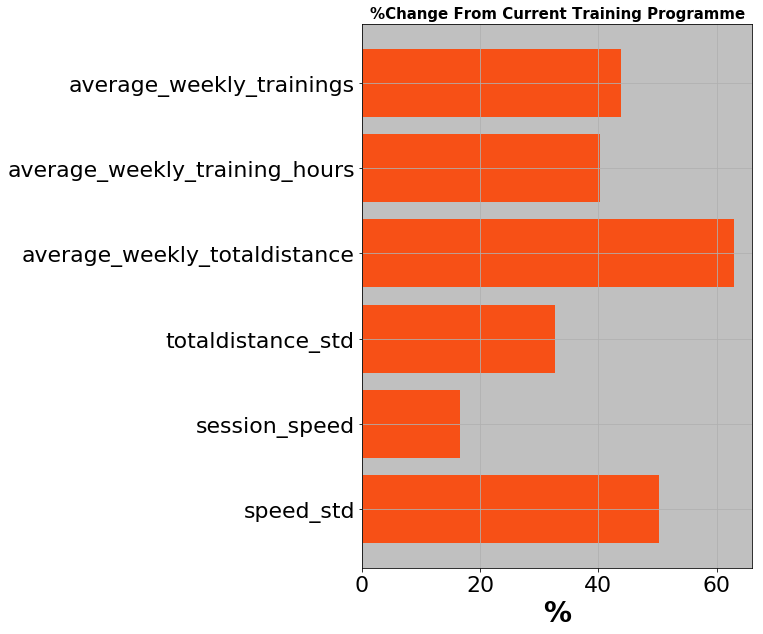

In [32]:
fig, ax = plt.subplots(figsize=(7,10))
y=['average_weekly_trainings','average_weekly_training_hours','average_weekly_totaldistance','totaldistance_std','session_speed','speed_std']
ax.barh(y,percentage_difference, align='center', ecolor='black',color='#f75016')
ax.invert_yaxis()  
ax.set_xlabel('%',color='k')
ax.tick_params(axis='x',colors='k')
ax.set_facecolor('#c0c0c0')
ax.set_title('%Change From Current Training Programme',size=15,color='k')
plt.show()